# NUISANCE3 GENIE Data Comparison Tutorial

## Front matter (Expand for build/run instructions)

### Working with containers

This tutorial requires a full build of NUISANCE3 linked against GENIE, nusystematics, and NUISANCE2. You can use the `picker24/pittpaccbox:latest` container image to build NUISANCE3 in as below:

Start the container, this command mounts your home directory as the root user's home directory inside the container, so you can persist/read/write files in your home directory from within the container. The `PS1` mess just sets a shell prompt that makes it clear when a terminal is 'inside' a container.

```bash
docker run -it --rm --volume ${HOME}:/root -w /root -e PS1="\[\e[1m\e[31m\]pittpaccbox\[\e(B\e[m\]:\[\e[1m\e[32m\]\$(basename \$(pwd)) $\[\e(B\e[m\] " picker24/pittpaccbox:latest
```

You can add something like the below to your shell's dotfile (`~/.zshrc` or `~/.bashrc`) to make this less obtrusive:

```bash
function docker_run {
  docker run -it --rm --volume ${HOME}:/root -w /root -e PS1="\[\e[1m\e[31m\]pittpaccbox\[\e(B\e[m\]:\[\e[1m\e[32m\]\$(basename \$(pwd)) $\[\e(B\e[m\] " "${@}"
}
```

and then restart your shell and use: `docker_run picker24/pittpaccbox:latest`

### First time set up

Clone the software:
```bash
cd ~/where/you/want/to/work
git clone https://github.com/NUISANCEMC/nuisance.git
git clone https://github.com/NuSystematics/nusystematics.git
git clone https://github.com/NUISANCEMC/nuisance3.git
```

build `NUISANCE2` and `nusystematics`:
```bash
cd nusystematics; mkdir build; cd build
cmake ..; make install -j4
source Linux/bin/setup.nusystematics.sh
cd ../../ 

cd nuisance; mkdir build; cd build
cmake .. -DNuHepMC_ENABLED=ON -DGENIE_ENABLED=ON; make install -j4
source Linux/setup.sh
cd ../../ 
```

build `NUISANCE3` and test that the python bindings work:
```python
git clone https://github.com/NUISANCEMC/nuisance3.git
cd nuisance3; mkdir build; cd build
cmake .. -DNUISANCE_LEGACY_INTERFACE=ON
make install -j 4
source Linux/bin/setup.ProSelecta.sh
source Linux/bin/setup.NUISANCE3.sh
cd ../../
python3 -c "import pyNUISANCE"
```
If you don't get any horrible errors here, you've built everything correctly!

finally, start Jupyter:
```python
mkdir myanalysis; cd myanalysis
wget https://raw.githubusercontent.com/NUISANCEMC/notebooks/refs/heads/main/NUISANCE3TutorialDec24.ipynb
jupyter lab --allow-root --no-browser --ip 0.0.0.0 --LabApp.token=''
```

If you are using (orbstack)[https://orbstack.dev], then go to https://orb.local in a browser and click on the container running jupyter and jupyterlab should appear.

### Starting again where you left off

If you close the container, or reboot your laptop, you don't need to rebuild all the software (as long as you built it originally in a place outside of the container, such as your home directory). Just navigate to `~/where/you/want/to/work` and run:

```bash
source nusystematics/build/Linux/bin/setup.nusystematics.sh
source nuisance/build/Linux/setup.sh
source nuisance3/build/Linux/bin/setup.ProSelecta.sh
source nuisance3/build/Linux/bin/setup.NUISANCE3.sh
```

to set up the environment again, and then you can restart Jupyter/rebuild the software.

### Making changes to the code

You can use a second container to rebuild `nusystematics` (make sure to `make install`) without interrupting your jupyter container. After rebuilding, you will need to restart the kernel to pick up any changes (and rerun as much of the notebook as required up to the current cell). If you make changes to any of the header files in `nusystematics`, its best to also rebuild NUISANCE3 too (again, make sure to `make install`). You will again need to restart the kernel.

Sometimes rebuilding NUISANCE3 will rerun cmake, which will fail with horrible issues to do with not finding `libCURL`. If this happens, just empty the build directory, reconfigure, and rebuild. This usually only happens if you change a `CMakeLists.txt`, which triggers cmake to re-configure the build.

### Things to try if you get stuck

Most of the python bindings for NUISANCE will give you *something* if you run `help(pn.HistFrame)`, for example. Showing you available functions and argument lists. They don't contain full documentation at this time, but if you expect something to be available that isn't demonstrated in this tutorial, you can try asking for `help`.

You can ask on the NUISANCE slack nuisance-xsec.slack.com, If you don't have access, you can email `luke.pickering@stfc.ac.uk` or `p.stowell@sheffield.ac.uk` asking to be added, saying what experiment you work on and that you would like to be able to ask for support on slack.

You can also read the source code, both the C++ and the python bindings, the NUISANCE3 repository is here: https://github.com/NUISANCEMC/nuisance3

*If the notebook crashes*: You may get messages about the kernel seeming to stop. Usually this is a crash in the C++ code, unfortunately jupyter doesn't properly propagate any useful crash information to let you diagnose/fix. I usually try and copy the minimal amount of python code to reproduce the crash to a `test.py` file and execute it under gdb like `gdb --args python3 test.py`, when this crashes, you should get a stack trace and can pause execution inside the C++ code to further diagnose things. The worst case is where it doesn't crash under `gdb`/`python3` interpreter but does in jupyter, luckily, this rarely happens.

## Tutorial Proper

In this tutorial we will work through generating/reading/analysing and comparing some GENIE predictions to some MINERvA data. We will also show how `nusystematics` can be used to reweight those predictions to mock up the effect of varying physics parameters in the model.

In [1]:
import pyNUISANCE as pn
import matplotlib.pyplot as plt

Nuisance: Neutrino Interaction Systematics from A-Neutrino sCattering Experiments  -- You can always find a frame
[ NUISANCE ]: Loading DEFAULT settings from : /root/software/NUISANCEMC/nuisance/build/Linux/parameters/config.xml
[ NUISANCE ]: Finished nuisconfig.
Welcome to JupyROOT 6.30/04


# Generate Some Events

We'd like to generate some events to use for later analysis. We can do this without leaving Jupyter by using some bash cell magic.

First check that some relevant environment variables are set.

In [2]:
%%bash
echo $GENIE_XSEC_TUNE
echo $GENIE_XSEC_FILE

AR23_20i_00_000
/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz


Then generate some events with `gevgen`, we will use a CH target, which can be specified as: `1000060120[12],1000010010[1.00784]`. We will ask NUISANCE2 for the flux specification.

In [3]:
%%bash
# uncomment to force regeneration
# rm genie_CH.MINERvA_LE.ghep.root
if [ ! -e genie_CH.MINERvA_LE.ghep.root ]; then
    gevgen -e 0.1,10 \
           -f $($NUISANCE/bin/nuis-flux MINERvA -P numu -M nu) \
           -p 14 -t 1000060120[12],1000010010[1.00784] \
           -n 500000 \
           --tune $GENIE_XSEC_TUNE --cross-sections $GENIE_XSEC_FILE \
           --event-generator-list Default \
           -o genie_CH.MINERvA_LE.ghep.root &> genie.run.log
  if [ "$?" != 0 ]; then
    head -200 genie.run.log
  fi
fi

See the GENIE Physics and User manual for more information on using `gevgen`: https://www.overleaf.com/project/636a7db08c037d85efd5b1a2

# Read in the Events

To read in a stream of events in pyNUISANCE (NUISANCE3), we use an `EventSource`. This can be passed a file path as a string and it will attempt to read the pointed to file. NUISANCE3 can read a variety of formats via plugins, which plugins are available depend on the generator libraries found when NUISANCE was built. Specific plugins sometimes require more information than just the file path, alternatively, as below, a dictionary of information can be passed to `EventSource`. Below we see that to read the GENIE file that we just generated, we need to tell NUISANCE some extra information about the generation, this is so that it can determine the Flux-Averaged Total Cross Section (FATX) for the generator run. If you are used to NUISANCE2, the FATX/number of events is equivalent to the `fScaleFactor` that you may have to use to correctly normalize event predictions. In NUISANCE3 we use the sum of the event weights, rather than just the number of events in the denominator, to account for event generators that produce weighted samples.

In [4]:
gevs = pn.EventSource({"event-generator-list":"Default",
                       "tune":"AR23_20i_00_000",
                       "spline_file":"/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz",
                       "filepath": "genie_CH.MINERvA_LE.ghep.root"})
if not gevs:
    print("Failed to read event file")

1734717781 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734717781 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734717781 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734717781 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734717782 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_A = 0
1734717782 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A < 420 -> using MagFF_RT_A = 5.19
1734717782 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_B = 1
1734717782 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A

By default, NUISANCE3 will refuse to read in events that it cannot determine the FATX for. If you want to read such events, you can use an `UnNormalizedEventSource` and then provide an FATX externally. The reason that this approach is more involved is becuase knowing the FATX for an input file is critical to almost all of the NUISANCE's function and so forcing through an un-normalisable file is an expert operation.

In [5]:
# fgevs = pn.UnNormalizedEventSource("genie_CH.MINERvA_LE.ghep.root").force_fatx(1, pn.nhm.FATXUtils.cm2ten38_PerNucleon)

The stream of events retrieved from an `EventSource` is always in HepMC3 format, if the events on disk are not HepMC3 events (as in this case, where they are GHEP) then they are converted on the fly. A python event loop might be written as follows:

```python
for ev, w in gevs:
  #do something with each event
```

You can find more out about HepMC3 here: https://gitlab.cern.ch/hepmc/HepMC3

However, we do not recommend using python event loops for analysis, so read on for the preferred workflow.

# Do some analysis

NUISANCE3 python analyses follow a 'dataframe' or 'columnar' workflow. The input event stream is converted to tabular data where each row corresponds to a single event and each column corresponds to some event property or projection of the event. An `EventFrameGen` instance is used to define and then execute this workflow.

Below we can see the columns that all `EventFrame`s contain by default.

The `first(20)` call tells the `EventFrameGen` to only read the first 20 events from the input event stream before returning the `EventFrame`.

In [6]:
ef = pn.EventFrameGen(gevs).first(20)
print(ef)

 -----------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |
 -----------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 |
 |            5 |         1 |      0.01588 |     0.004848 |        500 |
 |            6 |         1 |      0.01512 |     0.004081 |        650 |
 |            7 |         1 |      0.01491 |     0.003942 |        600 |
 |            8 |         1 |      0.01439 |     0.003539 |        500 |
 |            9 |         1 |      0.01401 |     0.003284 |        600 |
 |           10 |         1 |      0.01364 |     0.

Every `EventFrame` contains a running calculation of the normalisation information so that a correct cross section prediction can be made easily with a subset of the input event stream (providing that every event starting from the first one is considered). It also contains the generator-dependent `process_id`. If these Id's are 3 digits, they may follow the NuHepMC specification: `E.C.1` from https://arxiv.org/pdf/2310.13211

The canonical way to check if E.C.1 is being followed is to check the `NuHepMC.Conventions` attribute on the `HepMC3::GenRunInfo`, if it contains `E.C.1` then it is likely that it is being followed.

In [7]:
gevs.run_info().attribute_as_string("NuHepMC.Conventions")

'G.C.1 G.C.2 G.C.4 E.C.1 V.C.1 P.C.1 P.C.2 E.C.2'

`EventFrameGen` support both one-shot or batched processing depending on file size and memory pressure. An example of batched processing would be:

```python
evf = pn.EventFrameGen(gevs)
# Add some columns to evf
ef_batch = evf.first(20)
while ef_batch:
  # do some analysis on the EventFrame batch
  ef_batch = evf.next(20)
```

For the rest of this tutorial we will produce and consume the entire `EventFrame` in one go, like:

```python
evf = pn.EventFrameGen(gevs)
# Add some columns to evf
ef = evf.all()
```

## Columnar Analysis

New columns for processing are defined by a name and a function that takes a HepMC3 event and returns a single number (which will be converted to a double as needed). These functions can be written in python or ProSelecta (https://github.com/NUISANCEMC/ProSelecta/blob/main/README.md) can be used to write them in C++, compile them, and generate python handles to them. For clarity in this tutorial we will write them in python using `pyProSelecta` helper functions where neccessary.

We will add a few simple column functions that might be useful for a pion analysis.

In [8]:
from pyProSelecta import event, part, unit, pdg, p3mod, momentum, ext
from pyNuHepMC import EventUtils
from pyHepMC3.pyHepMC3.HepMC3 import FourVector

def numpi(ev):
    return event.num_out_part(ev, [211,-211,111], flatten=True)

def invariant_hadronic_mass(ev):
    # get the hard scatter vertex
    pv = EventUtils.GetPrimaryVertex(ev)
    p4 = FourVector(0,0,0,0)
    # sum all non lepton out-going particles
    for p in pv.particles_out():
        pid_abs = abs(p.pid())
        if (pid_abs > 16) and (pid_abs < 1000000000):
            p4 = p4 + p.momentum()
    return p4.m() / unit.GeV_c2

efg = pn.EventFrameGen(gevs) \
        .add_column("enu", ext.enu_GeV) \
        .add_column("q0",ext.q0lep_GeV) \
        .add_column("q3",ext.q3lep_GeV) \
        .add_column("Q2", ext.Q2lep_GeV2) \
        .add_column("W_vtx", invariant_hadronic_mass) \
        .add_column("numpi", numpi) \

print(efg.first(20))

 -----------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |   enu |     q0 |     q3 |       Q2 |  W_vtx | numpi |
 -----------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 | 2.921 |  2.586 |  2.909 |    1.773 |  1.886 |     0 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 | 2.815 | 0.2459 | 0.3617 |  0.07037 |      0 |     0 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 | 2.486 | 0.8143 |  1.014 |   0.3658 |  1.429 |     2 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 | 3.895 | 0.3345 | 0.8541 |   0.6177 | 0.9383 |     0 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 | 2.019 | 0.2972 | 0.8309 |   0.6021 |  

We might want to only analyse events with certain properties. There are a number of ways that we can make cuts and they depend on what our onward analysis looks like. We can add a filter on the `EventGenFrame` which will stop events being processed at all if they fail to pass the filter function. Sometimes we may want to perform multiple, orthogonal analyses on a single input file. We can build an `EventFrame` for each analysis with different filters and columns, but it can also be useful to add 'flag' or 'category' columns that can later be used to divide up event samples.

Below, we will show an example of both, we will filter on events with 0 final state leptons (likely NC interactions), and then add a categorisation column which can be used to divide the sample into 5 categories based on the number and species of final state pions in an event.

In [9]:
def numclep(ev):
    return event.num_out_part(ev, pdg.kChargedLeptons, flatten=True)

def pioncategory(ev):
    npip, npim, npi0 = event.num_out_part(ev, [211,-211,111])
    npi = (npip+npim+npi0)

    if npi == 0:
        return 0
    elif npi == 1:
        if npip == 1:    
            return 1
        if npim == 1:    
            return 2
        if npi0 == 1:    
            return 3
    return 4

efg.filter(lambda ev: numclep(ev)).add_column("pioncategory", pioncategory)

ef = efg.all()
print(ef)

 --------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |   enu |     q0 |     q3 |       Q2 |  W_vtx | numpi | pioncategory |
 --------------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 | 2.921 |  2.586 |  2.909 |    1.773 |  1.886 |     0 |            0 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 | 2.815 | 0.2459 | 0.3617 |  0.07037 |      0 |     0 |            0 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 | 2.486 | 0.8143 |  1.014 |   0.3658 |  1.429 |     2 |            4 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 | 3.895 | 0.3345 | 0.8541 |   0.6177 | 0.9383 |     0 |            0 |
 |    

Comparing the `event.number` column and the `process.id` column, we can see that some events don't make it into this filtered table at all, and there are no longer process ids of the form `x5x`, which in the NuHepMC convention correspond to NC channels.

The pioncategory column holds a labelling integer corresponding to the following topologies:
* 0: CC0Pi
* 1: CC1Pi+
* 2: CC1Pi-
* 3: CC1Pi0
* 4: CCNPi

Now we're ready to make some plots!

## From EventFrames to HistFrames

NUISANCE3 comes with its own Histogramming library. The histogram type is called a `HistFrame`. It might initially be confusing that we have `EventFrame`s and `HistFrame`s, but they both end up being quite powerful for analysis. Remember, in an `EventFrame`, each row corresponds to an event and the different columns correspond to different event properties. In a `HistFrame`, each row corresponds to a bin, and each column corresponds to a distinct set of bin values and errors. You will see why this is a useful object soon.

First, lets just plot the neutrino energy distribution for our selected CC events. The python bindings for `HistFrame`s come with an interface to `matplotlib` to make rapid prototyping of analysis simple, for more complicated plots, you may need to take the values and bins from your `HistFrame` and plot them using the full `matplotlib` library.

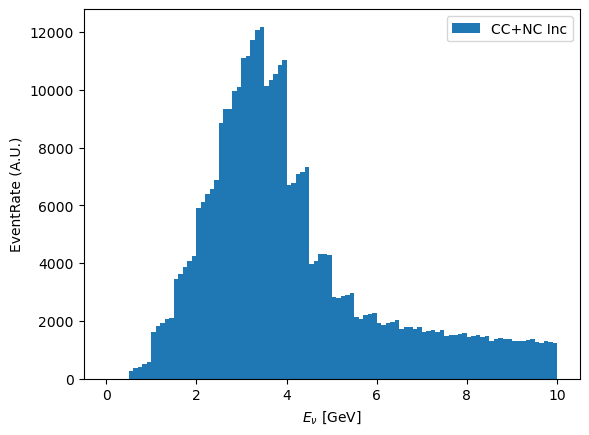

In [10]:
enu_h = pn.HistFrame(pn.Binning.lin_space(0,10,100,r"$E_{\nu}$ [GeV]"), "CC+NC Inc", "EventRate (A.U.)")
enu_h.fill(ef, "enu")
enu_h.mpl().hist()

plt.legend()
plt.show()

You can see that we have defined a simple uniform binning with `pn.Binning.lin_space` that takes arguments defining a start, stop, number of bins. We have annotated the axis with a label, the histogram with a title and a y-axis label, both can contain a subset of latex that matplotlib will render for you.

We then fill the histogram from the `EventFrame` specifying the name of the `EventFrame` column that we want to plot.

Simple!

There are a few ways that we can perform more-advanced `fill` operations with the same input `EventFrame`. We can use a column name as a boolean for whether to fill with an event property or not. Events with a value of 0 are skipped, those with any other value will be filled. Below we show how to make a version of the above plot that only contains events with pions. As we are now specifying a more complex fill operation, we have to be explicit about which `HistFrame` column to fill, which can be done by name or index. If a non-existant column name is passed to `fill_column`, then a new column will that name will be created and filled, as in the example below. We will then plot the first column, which was filled above, overlaid by the second column, which only contains events with one or more final state pion.

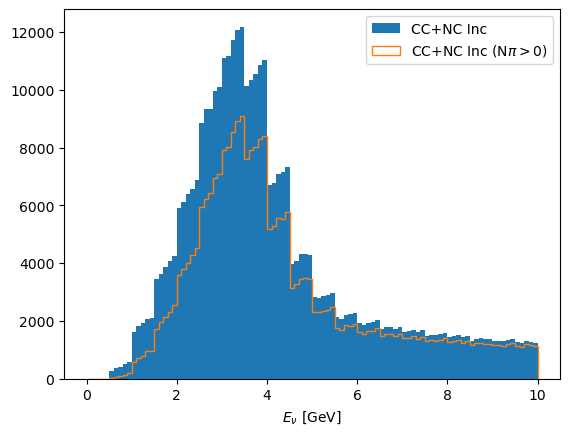

In [11]:
enu_h.fill(ef, "enu", [pn.HistFrame.fill_column("CC+NC Inc (N$\pi > 0)$"), pn.HistFrame.fill_if("numpi")])

enu_h.mpl().hist()
enu_h.mpl().hist(column="CC+NC Inc (N$\pi > 0)$", histtype="step")

plt.legend()
plt.show()

Beyond just using an `EventFrame` column as a cut, below we demonstrate using the `pioncategory` column to categorize events, and then the `hist_all` helper to plot all categories in one function call.

We will start with a fresh histogram, every event is used to fill the `"Total"` column, which is column 0, but they also fill a column from 1 to 5 based on the value of the `"pioncategory"` for that event.

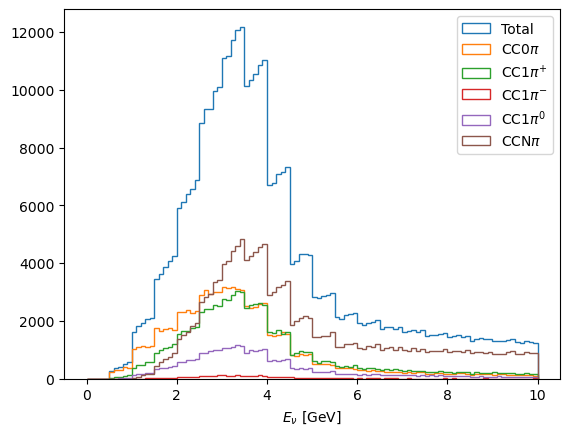

In [12]:
enu_h = pn.HistFrame(pn.Binning.lin_space(0,10,100,r"$E_{\nu}$ [GeV]"), "Total", "EventRate (A.U.)")
enu_h.fill(ef, "enu", [pn.HistFrame.fill_column("Total"), 
                       pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"])])

enu_h.mpl().hist_all(histtype="step")

plt.legend()
plt.show()

You might think that the above plot looks odd. It is always a good idea when analysing a generation output for the first time to plot the neutrino energy distribution and check that it looks sensible, this can highlight many bugs that might be harder to spot in different projections. Here, the saw-toothing is not ideal, but is expected from how GENIE throws events from a flux histogram.

Finally, in this section, we will use the pion category column to analyse the four momentum transfer and hadronic mass at the hard-scatter vertex of events containing pions. The example below will contain less commentary, but serves as a demo for what we can achieve with the NUISANCE3 `EventFrame`s, `HistFrame`s and a bit of `matplotlib`.

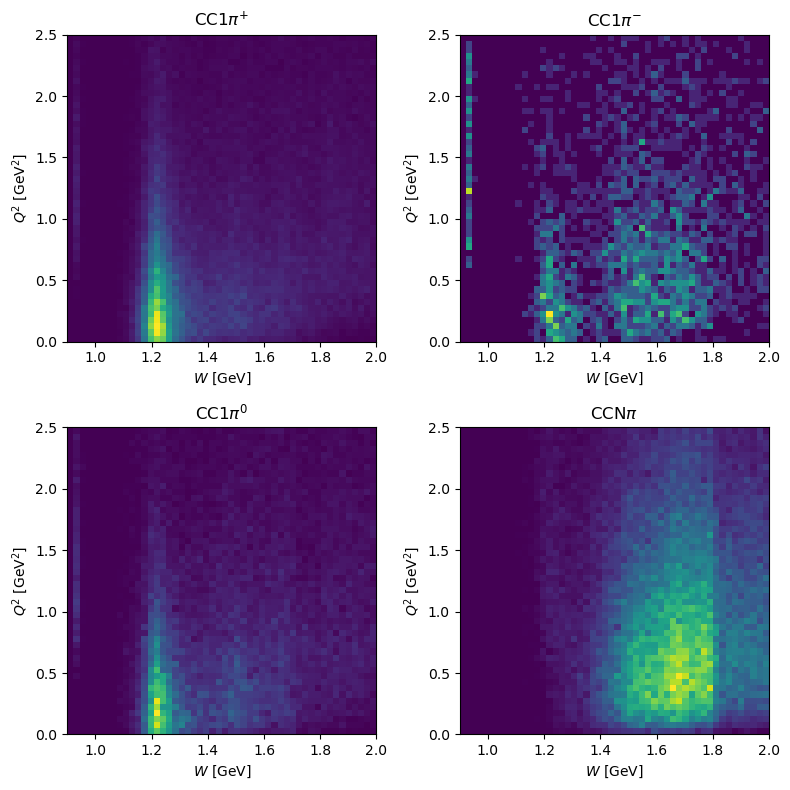

In [13]:
WQ2_h = pn.HistFrame(pn.Binning.lin_spaceND([[0.9,2,50],[0,2.5,50]],[r"$W$ [GeV]", r"$Q^{2}$ [GeV$^{2}$]"]), "Total", "EventRate (A.U.)")

WQ2_h.fill(ef, ["W_vtx", "Q2"], [pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"]),])

fig, axes = plt.subplots(2,2, figsize=(8,8))

WQ2_h.mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[0][0])
plot_axis=axes[0][0].set_title("CC1$\pi^{+}$")

WQ2_h.mpl().colormesh(column="CC1$\pi^{-}$", plot_axis=axes[0][1])
plot_axis=axes[0][1].set_title("CC1$\pi^{-}$")

WQ2_h.mpl().colormesh(column="CC1$\pi^{0}$", plot_axis=axes[1][0])
plot_axis=axes[1][0].set_title("CC1$\pi^{0}$")

WQ2_h.mpl().colormesh(column="CCN$\pi$", plot_axis=axes[1][1])
plot_axis=axes[1][1].set_title("CCN$\pi$")

fig.tight_layout()
fig.show()

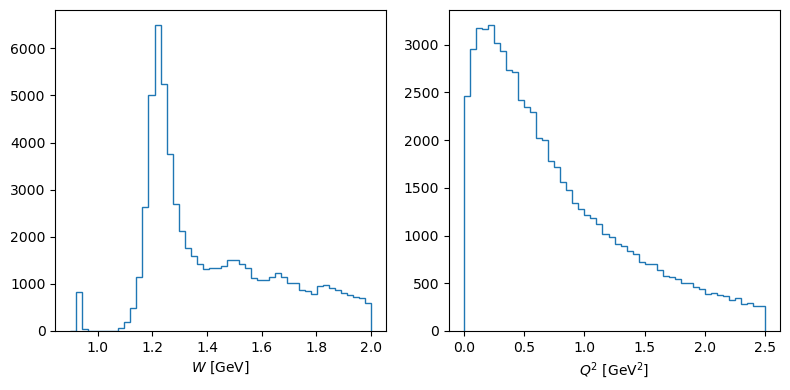

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

WQ2_h.project(0).mpl().hist(histtype="step", plot_axis=axes[0], column="CC1$\pi^{+}$")
WQ2_h.project(1).mpl().hist(histtype="step", plot_axis=axes[1], column="CC1$\pi^{+}$")

fig.tight_layout()
plt.show()

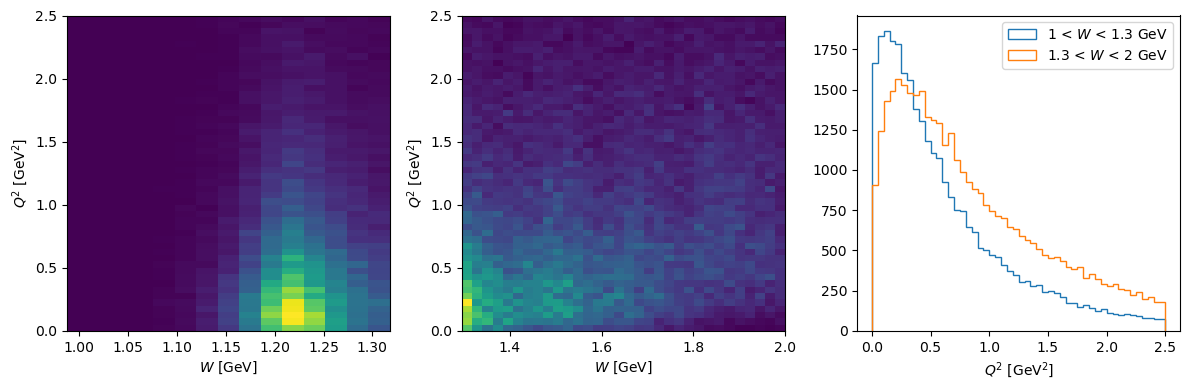

In [15]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

WQ2_h.slice(0, [1,1.3]).mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[0])
WQ2_h.slice(0, [1.3,2]).mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[1])

WQ2_h.slice(0, [1,1.3]).project(1).mpl().hist(histtype="step", column="CC1$\pi^{+}$", label="1 < $W$ < 1.3 GeV", plot_axis=axes[2])
WQ2_h.slice(0, [1.3,2]).project(1).mpl().hist(histtype="step", column="CC1$\pi^{+}$", label="1.3 < $W$ < 2 GeV", plot_axis=axes[2])

fig.tight_layout()
plt.legend()
plt.show()

**N.B.** The slice functions above include the bins in which the ends of the ranges fall, and all bins between. Bins in the sliced dimension are never split. Passing a single value, like:

```python
q0q3_h.slice(0, 1.25)
```
will select a single bin along axis 0 and produce a 1D histogram. If a range is given, and multiple bins are selected in the sliced dimension, then a 2D histogram will be produced.

# Cross Section Predictions

So far we have been making histograms of events. Ultimately, we want to produce cross section predictions. To do this, we need to normalise by the FATX of the generator run. NUISANCE3 tries to make this as painless as possible. We can get the FATX/sum of event weights, which is the quantity we will need to scale a histogram of event properties by to get the normalisation correct. The final step is to divide by the width of each bin so that the area under the 'histogram' integrates to equal the fraction of the FATX for the events included in the histogram (if cuts are applied).

We retrieve the FATX/sumweights from the event stream *after* it has been processed. We have to be careful to retrieve the `norm_info` object when the reading of the events has completed, if we accidentally restart the event stream by calling `first` or looping on events from it, the `norm_info` will not be correct for the `EventFrame` we have produced. Its best to re-build the EventFrame from scratch and then store the FATX information immediately.

When retrieving the `norm_info`, we must specify the units we want the FATX in. A common convention is $10^{-38} \mathrm{cm}^{2} /\mathrm{Nucleon}$. The pyNuHepMC library has constants defining common unit conventions that we can use, as below.

In [16]:
ef = efg.all()
gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)

print(f"GENIE FATX = {gnorm.fatx:.5f} cm^2 10^-38 /N")

GENIE FATX = 3.52922 cm^2 10^-38 /N


Now we can make a differential cross section prediction. When making a differential cross section prediction, we want the integral under the 'histogram' to correspond to the total flux-averaged cross section for that prediction, hence, differential, each bin contains a small part of the cross section. To get this correct, we must divide the sum of the weights in a bin (the bin content or value) by the hyper-volume of the bin: width for 1D bins, area for 2D bins, volume for 3D bins, etc... You can also remind yourself of this by looking at what the y axis represents, $d\sigma/dQ^{2}$: we are approximating this by a prediction of $\Delta{}\sigma/\Delta{}Q^{2}$, where each bin with a width $\Delta{}Q^{2}$ contributes $\Delta{}\sigma$ to the total cross section for our prediction. So, you need to divide by the width in $Q^2$ to correctly predict the quantity of interest.

`HistFrame`s know their own bin hyper-volumes, the `finalise(True)` call in the below code performs that bin hyper-volume division for us. If you don't want to divide by the bin width you can skip calling `finalise` or call `finalise(False)`.

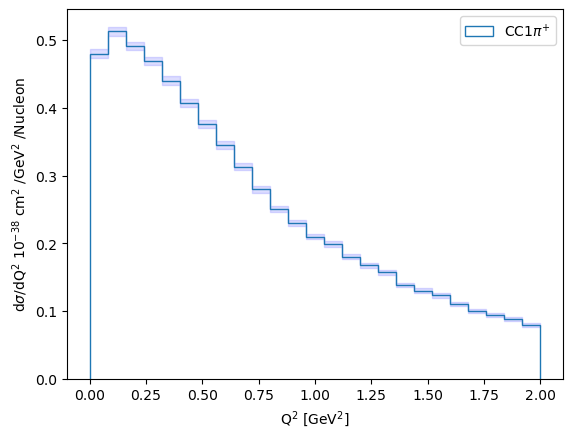

In [17]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")
Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("Total"), 
                     pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"])])
Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True).mpl().hist(histtype="step", column="CC1$\pi^{+}$", errorband_color="#00F2")
plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

## Non-uniform Binning

There are a variety of other methods for specifying a binning scheme in NUISANCE3. We won't go in to a lot of detail, but will show an example of how you might make a 2D non-uniform binning scheme with some externally supplied bin edges.

We will make a simple 2D distribution in $Q^{2}$ and $W$, with $Q^{2}$ bin edges at `[0,0.1,0.2,0.5,1,3]` and $W$ bin edges at `[1.1,1.2,1.3,1.5,1.7,2,3]`

If you can get the bin edges from a text file or a root histogram from a measurement's data release, you can now manually build, fill, and finalise a cross section prediction for that measurement!

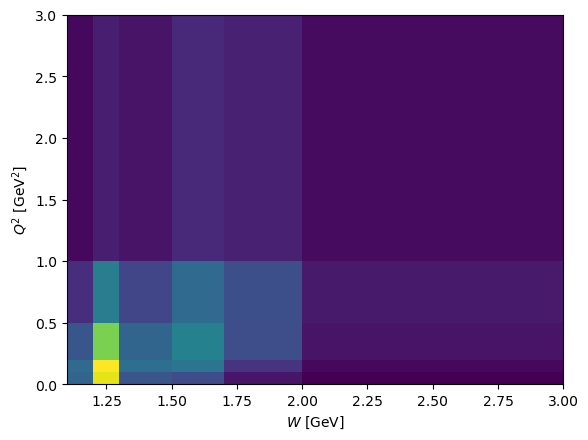

In [18]:
q2bins = pn.Binning.contiguous([0,0.1,0.2,0.5,1,3], r"$Q^{2}$ [GeV$^{2}$]")
wbins = pn.Binning.contiguous([1.1,1.2,1.3,1.5,1.7,2,3], r"$W$ [GeV]")

WQ2_h = pn.HistFrame(pn.Binning.product([wbins, q2bins]))
WQ2_h.fill(ef, ["W_vtx", "Q2"])
WQ2_h.finalise(True).mpl().colormesh()
plt.show()

# Calculate Some Weights

In this section we show how event reweighting fits into the above framework. This will neccessarily be somewhat framework specifc, in this case DUNE/SBN's `nusystematics` package. We will not overly document specific details needed to get the framework running

## nusystematics

First we need a config file, below we've just defined one in a bash HEREDOC to use.

In [19]:
%%bash

cat > tool_config.fcl << EOF

ResIso_config: {
    tool_type: "ResIso"

    alldial_variation_descriptor: "(-3,3,1)"
  }

syst_providers: [ResIso_config]

EOF

GenerateSystProviderConfigNuSyst -c tool_config.fcl -o tool_headers_prolog.fcl
cat tool_headers_prolog.fcl | grep -v "PROLOG" > tool_headers.fcl

# uncomment to cat the whole generated file
# cat tool_headers.fcl

[GenerateSystProviderConfigNuSyst] input
ResIso_config: {
   alldial_variation_descriptor: "(-3,3,1)"
   tool_type: "ResIso"
}
syst_providers: [
   "ResIso_config"
]

1734717833 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734717833 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734717833 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734717833 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
Wrote systematic provider configuration with md5: "7055e3eca02f8640ecedcbf7c7088e1d" to "tool_headers_prolog.fcl"


We need a WeightCalcFactory to make instances of the reweighting objects, below we create a `nusystematics`-type weight calculator and initialise it with the configuration file from above

In [20]:
wf = pn.WeightCalcFactory()
nusyst = wf.make(gevs, {"plugin_name": "nusystematics",
                       "param_headers": "tool_headers.fcl"})

[INFO]: Syst provider "ResIso" configured 36 parameters.


The two main interfaces we need from the weighter are how to set parameters, and how to calculate weights. Parameter names and the interpretation of parameter values are entirely implementation defined. NUISANCE makes no attempt at all to intercept and homogenise parameter names/types/values. To effectively use a systematic variation framework, you need to understand how that framework works, NUISANCE just lets you programatically interface with it.

Below we set a parameter to a value of 1, and add the weight associated with that parameter variation to an `EventFrame`.

In [21]:
nusyst.set_parameters({"MaRes_ResCode0": 1})
efg = pn.EventFrameGen(gevs) \
        .add_column("Q2", ext.Q2lep_GeV2) \
        .add_column("w", nusyst.calc_weight)

ef = efg.first(20)
print(ef)

 ------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |       Q2 |     w |
 ------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |    1.773 |     1 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 |  0.07037 |     1 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 |   0.3658 |     1 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 |   0.6177 |     1 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 |   0.6021 |     1 |
 |            5 |         1 |      0.01588 |     0.004848 |        500 |    3.751 |     1 |
 |            6 |         1 |      0.01512 |     0.004081 |        650 |   0.6841 |     1 |
 |            7 |         1 |      0.01491 |     0.003942 |        600 |    0.85

As you can see, some events get weights.

These are all the building blocks you need to make systematically varied predictions with reweighting in NUISANCE3, but below we will demo a few more advanced techniques.

It is worth noting that reweight engines may not function correctly if multiple instances with different parameter values set are instantiated as they may possibly rely on global memory to perform their calculations for example (looking at you, NEUT reweight). So the 'safest' way is to wrap the `calc_weight` function in another function that sets the correct parameter value for that call. This might end up in a very slow `EventFrame` generation if setting parameters is computationally intensive for a given reweight implementation, but it can reasonably be expected to always give the right answer.

An example is given below:

In [22]:
def masres0_weighter(weighter, val):
    def calc_weight(ev):
        weighter.set_parameters({"MaRes_ResCode0": val})
        return weighter.calc_weight(ev)
    return calc_weight

efg = pn.EventFrameGen(gevs) \
        .filter(lambda ev: event.signal_process_id(ev) == 400) \
        .add_column("Q2", ext.Q2lep_GeV2) \
        .add_column("w -2", masres0_weighter(nusyst, -2)) \
        .add_column("w -1", masres0_weighter(nusyst, -1)) \
        .add_column("w -0.5", masres0_weighter(nusyst, -0.5)) \
        .add_column("w +0.5", masres0_weighter(nusyst, 0.5)) \
        .add_column("w +1", masres0_weighter(nusyst, 1)) \
        .add_column("w +2", masres0_weighter(nusyst, 2))

ef = efg.first(20)
print(ef)

 -------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |      Q2 |   w -2 |   w -1 | w -0.5 | w +0.5 |  w +1 |  w +2 |
 -------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |   1.773 |      1 |      1 |      1 |      1 |     1 |     1 |
 |           13 |         1 |      0.01212 |     0.002279 |        400 |  0.1498 | 0.6738 | 0.8642 | 0.9387 |  1.051 | 1.093 | 1.157 |
 |           17 |         1 |      0.01089 |     0.001818 |        400 |  0.8605 | 0.5353 | 0.7169 | 0.8479 |  1.166 | 1.341 | 1.692 |
 |           19 |         1 |     0.006684 |     0.001594 |        400 | 0.03538 |      1 |      1 |      1 |      1 |     1 |     1 |
 |           20 |         1 |     0.006497 |     0.0014

A slightly advanced/unintutive technique is used in the above example. When adding a column previously we have passed a function itself (not the result of calling a function). Now we pass what looks like the result of calling a function, but when we check what that result is, it is itself a function with some parameters pre-set. This just allows us to parameterise the wrapping of the `nusyst.calc_weight` call for ease of use. For this example, I also know that this systematic parameter only affects events that are process id == 400, so I applied a filter to increase the number of events in the first 20 processed that had weight responses.

These weight columns can now be used to approximate the continuous response of the parameter in question. Colloquially, we might call an interpolation function built from these 'knot' points (known parameter value-weight pairs), a 'spline'; specifically, in this case, an event spline. We plot the example for event number 13 in the above table, making use of the fact that the `EventFrame` instance can accessed like a numpy NDArray.

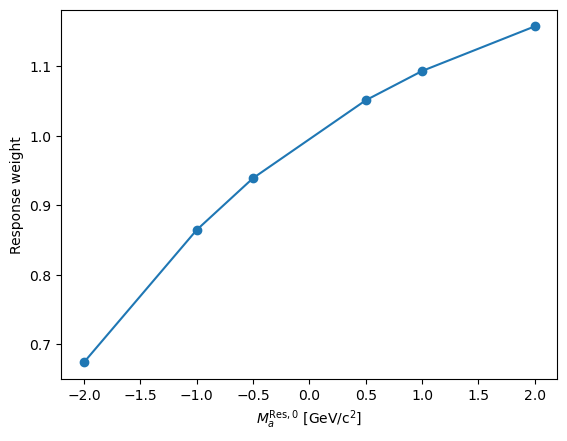

In [23]:
plt.scatter([-2,-1,-0.5,0.5,1,2], ef.table[1,6:12])
plt.plot([-2,-1,-0.5,0.5,1,2], ef.table[1,6:12])
plt.ylabel("Response weight")
plt.xlabel("$M_{a}^{\mathrm{Res},0}$ [GeV/c$^{2}$]")
plt.show()

Lets take a few seconds to build the entire table now, with all of the event spline inputs included.

In [24]:
ef = efg.all()

Now we can make a varied cross section prediction using these weights. To do so, we will need to use another of the fill operations, `weight_by`, which takes a column name from the input `EventFrame` to weight by.

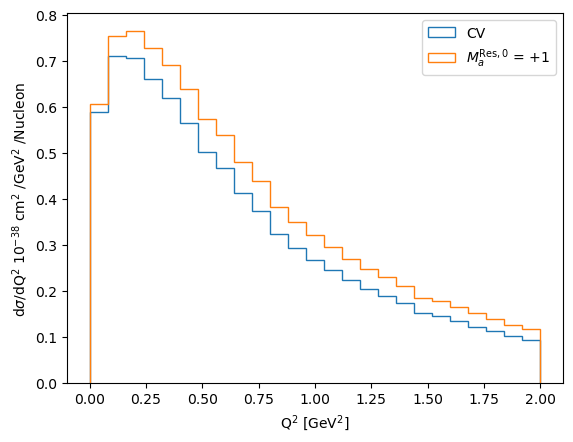

In [25]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")

Q2_h.fill(ef, "Q2")
Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("w +1"), 
                     pn.HistFrame.weight_by("w +1")])

Q2_h = Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True)

Q2_h.mpl().hist(histtype="step", column="Total", label="CV")
Q2_h.mpl().hist(histtype="step", column="w +1", label="$M_{a}^{\mathrm{Res},0}$ = +1")

plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

Because this operation is expected to be a common one, there is a dedicated fill operation that can be used to create a new `HistFrame` column, weighted by each of one or more `EventFrame` columns. Essentially, this can be used to translate *event splines* into *bin splines*.

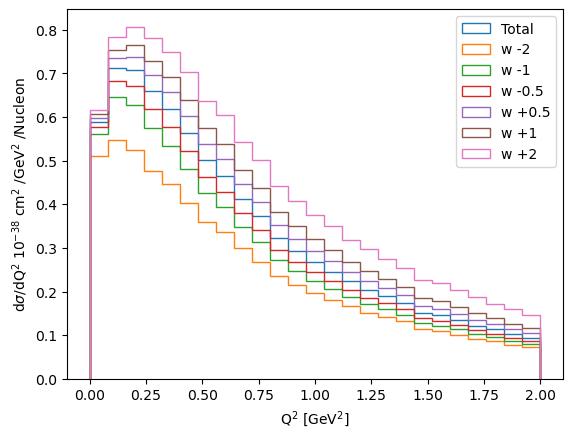

In [26]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")

Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("Total"), 
                     pn.HistFrame.weighted_column_map(["w -2", "w -1", "w -0.5", "w +0.5", "w +1", "w +2"])])

Q2_h = Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True)

Q2_h.mpl().hist_all(histtype="step")

plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

The final piece of the puzzle is interpolating between the calculated knot points. NUISANCE3 has some tools for helping with this step, but they are not yet fully formed, two approaches are given below.

The first adds a dummy column to the event frame, which we will then fill with the interpolated weight before each fill.

In [27]:
efg.add_column("weight_holder", lambda ev: 1)

In [28]:
ef = efg.all()
print(ef)

 ----------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |      Q2 |   w -2 |   w -1 | w -0.5 | w +0.5 |  w +1 |  w +2 | weight_hold$ |
 ----------------------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |   1.773 |      1 |      1 |      1 |      1 |     1 |     1 |            1 |
 |           13 |         1 |      0.01212 |     0.002279 |        400 |  0.1498 | 0.6738 | 0.8642 | 0.9387 |  1.051 | 1.093 | 1.157 |            1 |
 |           17 |         1 |      0.01089 |     0.001818 |        400 |  0.8605 | 0.5353 | 0.7169 | 0.8479 |  1.166 | 1.341 | 1.692 |            1 |
 |           19 |         1 |     0.006684 |     0.001594 |        400 | 0.03538 |      1 |      1 |

the `response` module of NUISANCE3 is a work in progress, but currently we have a natural cubic spline implementation that works with `EventFrames` and `HistFrames`. It takes the knot parameter values and the columns in the EventFrame corresponding to the event weights, and computes a spline for each row. This should be equivalent to a `TSpline3`, if you have used $\texttt{ROOT}$ interpolation before.

In [29]:
mares_resp = pn.response.NaturalCubicFrameSpline()
mares_resp.build([-2,-1,-0.5,0.5,1,2], ef.table[:,6:12])

This spline can be evaluated rapidly and written to the dummy column, which we can then use to make a varied prediction.

In [30]:
ef["weight_holder"] = mares_resp.eval(1.5)

We can now see that the `weight_holder` column contains values other than the `1`s that it was initialised with. Success!

In [31]:
print(ef)

 ----------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |      Q2 |   w -2 |   w -1 | w -0.5 | w +0.5 |  w +1 |  w +2 | weight_hold$ |
 ----------------------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |   1.773 |      1 |      1 |      1 |      1 |     1 |     1 |            1 |
 |           13 |         1 |      0.01212 |     0.002279 |        400 |  0.1498 | 0.6738 | 0.8642 | 0.9387 |  1.051 | 1.093 | 1.157 |        1.127 |
 |           17 |         1 |      0.01089 |     0.001818 |        400 |  0.8605 | 0.5353 | 0.7169 | 0.8479 |  1.166 | 1.341 | 1.692 |        1.516 |
 |           19 |         1 |     0.006684 |     0.001594 |        400 | 0.03538 |      1 |      1 |

We can now plot the interpolated histogram and check that it looks sensible

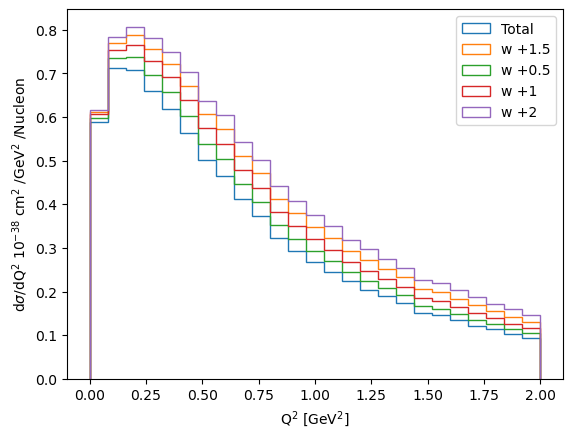

In [32]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")

Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("w +1.5"), 
                     pn.HistFrame.weight_by("weight_holder")])
Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("Total"), 
                     pn.HistFrame.weighted_column_map(["w +0.5", "w +1", "w +2"])])

Q2_h = Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True)

Q2_h.mpl().hist_all(histtype="step")

plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

The other way to do this is with another type of fill operation. This may seem simpler and more flexible than the above technique, but it requires that you manage an array of the same length as the `EventFrame`. It does mean that you can construct your event weights however you would like, rather than being constrained to using the NUISANCE3 framework. Here we pass the response of the event spline evaluation directly into the `weight_by_array` fill operation.

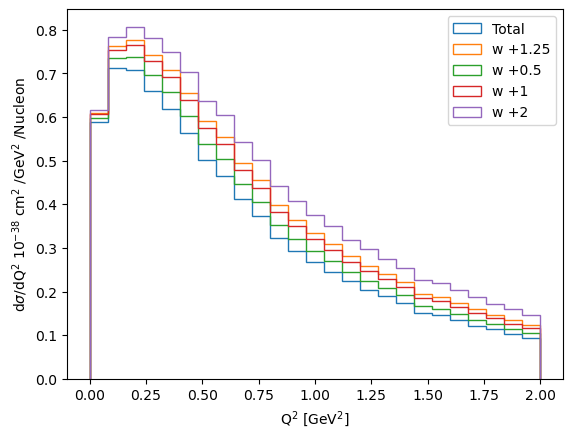

In [33]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")

Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("w +1.25"), 
                     pn.HistFrame.weight_by_array(mares_resp.eval(1.25))])
Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("Total"), 
                     pn.HistFrame.weighted_column_map(["w +0.5", "w +1", "w +2"])])

Q2_h = Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True)

Q2_h.mpl().hist_all(histtype="step")

plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

## A word of warning when using multiple parameters

In general, the event weight required to correctly capture the effect of varying two parameters simultaneously is not always the multiplication of the event weights from varying each parameter separately. Sometimes you need to build multidimensional response functions to properly make varied predictions, sometimes you live with the inaccuracy of assuming responses factorise, we cannot give a general recipe here.

In the future we hope to provide tools for building and propagating multi-dimensional response functions, but they are not yet ready. This doesn't mean that you cannot do such analyses in NUISANCE3, it just means that you might need to work a little more for correctness.

# Compare to some data

There are a variety of ways that you can compare to data with NUISANCE3. A non-exhaustive list is:
* Manually build a prediction in python using the tools described above to define selection/projection operators matching the measurement, use them to fill `EventFrames`, import and plot the data for official data-release root files and text files, import the associated error estimate, usually a matrix, calculate goodness of fit
* Use a NUISANCE3 HEPData record, which contains all of the information required to automatically quantitatively compare to data.
* Use the NUISANCE2 interface to fetch the data, selection, and projection functions of a sample implemented in NUISANCE2.

We're going to show a short example comparing to some MINERvA data via an implementation in NUISANCE2. First we need to choose a sample. The `nuissamples` script can be used to say all of the samples that NUISANCE2 knows about.

In [34]:
%%bash
nuissamples MINERvA | grep "pi" | grep -v "0pi"

MINERvA_CC1pip_XSec_1DTpi_nu
MINERvA_CC1pip_XSec_1DTpi_nu_20deg
MINERvA_CC1pip_XSec_1DTpi_nu_fluxcorr
MINERvA_CC1pip_XSec_1DTpi_nu_20deg_fluxcorr
MINERvA_CC1pip_XSec_1Dth_nu
MINERvA_CC1pip_XSec_1Dth_nu_20deg
MINERvA_CC1pip_XSec_1Dth_nu_fluxcorr
MINERvA_CC1pip_XSec_1Dth_nu_20deg_fluxcorr
MINERvA_CC1pip_XSec_1DTpi_nu_2017
MINERvA_CC1pip_XSec_1Dth_nu_2017
MINERvA_CC1pip_XSec_1Dpmu_nu_2017
MINERvA_CC1pip_XSec_1Dthmu_nu_2017
MINERvA_CC1pip_XSec_1DQ2_nu_2017
MINERvA_CC1pip_XSec_1DEnu_nu_2017
MINERvA_CC1pim_XSec_1DEnu_antinu
MINERvA_CC1pim_XSec_1DQ2_antinu
MINERvA_CC1pim_XSec_1DTpi_antinu
MINERvA_CC1pim_XSec_1Dpmu_antinu
MINERvA_CC1pim_XSec_1Dth_antinu
MINERvA_CC1pim_XSec_1Dthmu_antinu
MINERvA_CCNpip_XSec_1Dth_nu
MINERvA_CCNpip_XSec_1Dth_nu_2015
MINERvA_CCNpip_XSec_1Dth_nu_2016
MINERvA_CCNpip_XSec_1Dth_nu_2015_20deg
MINERvA_CCNpip_XSec_1Dth_nu_2015_fluxcorr
MINERvA_CCNpip_XSec_1DTpi_nu
MINERvA_CCNpip_XSec_1DTpi_nu_2015
MINERvA_CCNpip_XSec_1DTpi_nu_2016
MINERvA_CCNpip_XSec_1DTpi_nu_2015_20deg


Lets compare to `MINERvA_CC1pip_XSec_1DQ2_nu_2017`, we need to manually find some information out about the sample so that we can generate the right events for it. The NUISANCE3 HEPData format encapsulates that information in automatically parseable metadata, but for NUISANCE2 samples, we need to put in some leg work.

The sample implementation is here: https://github.com/NUISANCEMC/nuisance/blob/main/src/MINERvA/MINERvA_CC1pip_XSec_1D_2017Update.cxx
and the official data release is stored in NUISANCE here: https://github.com/NUISANCEMC/nuisance/tree/main/data/MINERvA/CC1pip/070717

We will need to some events generated with the MINERvA Low Energy flux on a hydrocarbon (CH) target. The keen-eyed amongst you will realise that those are the events we have been playing with for the entire notebook. However, if you needed to generate more/different events, or want to compare to a different experiment's data. NUISANCE2 has some copies of the neutrino flux distributions for a range of experiments, and GENIE-ready flux histogram description strings can be generated with the `nuis-flux` script, as shown below.

In [35]:
%%bash
$NUISANCE/bin/nuis-flux MINERvA -P numu -M nu

/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/minerva_le_flux.root,numu_fhc


Now we need to load the NUISANCE2 sample so that we can query it for the binning, data values, error matrix, and selection and projection functions.

In [36]:
rf = pn.RecordFactory()
nuis2 = rf.make_record({"type":"nuisance2"})
MINERvA_CC1pip_XSec_1DQ2_nu_2017 = nuis2.analysis("MINERvA_CC1pip_XSec_1DQ2_nu_2017")

[LOG Sample]:--  : Measurement1D.cxx::FinaliseMeasurement[l. 562] : Finalising Measurement: MINERvA_CC1pip_XSec_1DQ2_nu_2017
[Record:critical]: NUISANCE2Record::analysis(MINERvA_CC1pip_XSec_1DQ2_nu_2017)
[LOG Fitter]:  : SampleList.cxx::LoadPlugins[l. 449] : Searching for dynamic sample manifests in: /root/software/NUISANCEMC/notebooks/
[LOG Fitter]:  : SampleList.cxx::DynamicSampleFactory[l. 405] : Loaded 0 from 0 shared object libraries.
[LOG Sample]:--  : Measurement1D.cxx::FinaliseSampleSettings[l. 151] : Finalising Sample Settings: MINERvA_CC1pip_XSec_1DQ2_nu_2017
[LOG Sample]:--  : Measurement1D.cxx::SetDataFromTextFile[l. 203] : Reading data from text file: /root/software/NUISANCEMC/nuisance/build/Linux/data/MINERvA/CC1pip/070717/cc1pip_updated_1DQ2_data.txt
[LOG Sample]:--  : Measurement1D.cxx::SetCorrelationFromTextFile[l. 341] : Reading data correlations from text file: /root/software/NUISANCEMC/nuisance/build/Linux/data/MINERvA/CC1pip/070717/cc1pip_updated_1DQ2_ratecov.txt;8

[ERR WARN  ]: Allowing SVD inverse if matrices are singular, use with extreme caution!


We can then hook up the selection and projection functions from the NUISANCE2 implementation to an `EventFrameGen`, which will allow us to make predictions as we have already been doing. This may take a good few seconds (up to minutes) to run. The NUISANCE2 interface has to do a lot of event format conversion to function and so it can be a bit sluggish.

In [37]:
efg = pn.EventFrameGen(gevs) \
            .add_column("mnvq22017_sel", MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_selection().op) \
            .add_column("Q2", MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_projections()[0].op)

ef = efg.all()

gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)

We didn't apply the selection as a filter, this is because we may want to use the same events to make predictions for multiple MINERvA measurements that have different signal definitions. If we know we only want to make predictions for a single measurement, we can avoid some computation by applying a filter, like so:

```python
evfgen = pn.EventFrameGen(gevs) \
            .filter(MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_selection().op) \
            .add_column("Q2", MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_projections()[0].op)
```

In [38]:
print(ef)

 --------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id | mnvq22017_s$ |        Q2 |
 --------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |            0 | 3.736e+09 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 |            0 | 3.736e+09 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 |            0 | 3.736e+09 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 |            0 | 3.736e+09 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 |            0 | 3.736e+09 |
 |            5 |         1 |      0.01588 |     0.004848 |        500 |            0 | 3.736e+09 |
 |            6 |         1 |      0.01512 |     0.004081 |        650 |            0 | 3.736e+09 |


Now lets get the data from the NUISANCE2 sample, and plot that

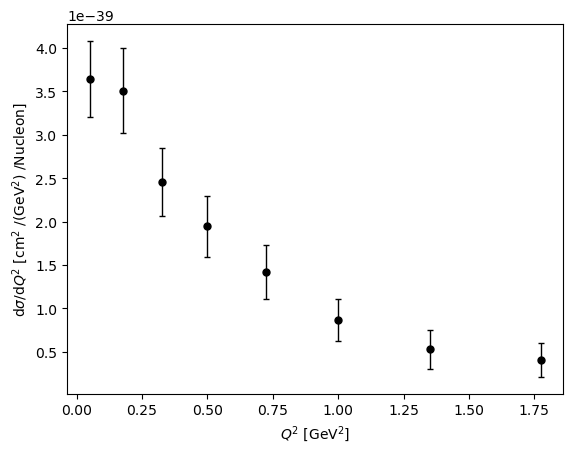

In [39]:
data = MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_data()[0]

data.mpl().data_hist(label="MINERvA Data")
plt.ylabel(r"d$\sigma$/d$Q^{2}$ [cm$^{2}$ /(GeV$^{2}$) /Nucleon]")
plt.xlabel(r"$Q^{2}$ [GeV$^{2}$]")

plt.show()

Now its simple to make a central value prediction from our `EventFrame`. 

First, we have to make a `HistFrame` that we can fill from the data object that we got from NUISANCE2. We haven't yet formally introduced a second type of histogram-like object, the `BinnedValues`, though we have already used them. A `BinnedValues` is similar to a `HistFrame`, except that it is *inert* in that it cannot be filled and only knows the error associated with each value, not the sum of weights squared, which is what the `HistFrame` keeps track of to estimate the poisson error. We can always make a fillable `HistFrame` from a `BinnedValues` with `make_HistFrame`, and we can `finalise` a `HistFrame` into a `BinnedValues`. Drawing such a distinction between these two types might smell like over-engineering, but there are a number of places where it is useful to keep the separation. As HEP experimentalists, we often pretend that histograms are estimates of some PDF that we want to know. Confusions can creep in when using the same type for both a fillable histogram and the best-estimate of the PDF that produced the samples that filled that histograms.

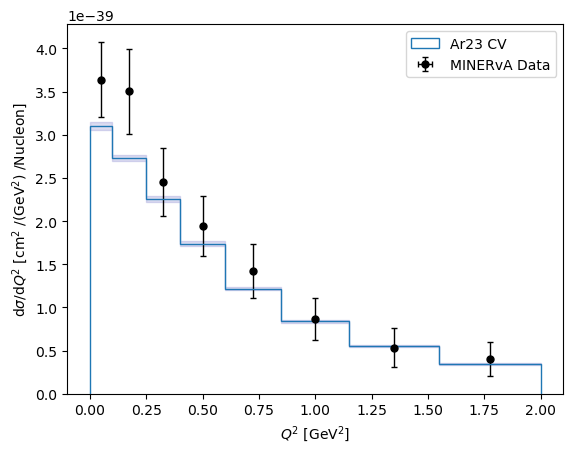

In [40]:
mc = data.make_HistFrame()

mc.fill(ef, "Q2")

# required because this analysis is in cm^2 /N not the nuisance2 default of 1E-38 cm2/N
ana_scale = 1E-38

# The True passed to finalise tells it to divide by the bin width, so that the returned 
# prediction can be treated as an estimate of the differential cross section
mcpred = mc.finalise(True).scale(ana_scale * gnorm.fatx_per_sumweights())

mcpred.mpl().hist(histtype="step", errorband_color="#0092", label="Ar23 CV")

data.mpl().data_hist(label="MINERvA Data")

plt.ylabel(r"d$\sigma$/d$Q^{2}$ [cm$^{2}$ /(GeV$^{2}$) /Nucleon]")
plt.xlabel(r"$Q^{2}$ [GeV$^{2}$]")

plt.legend()

plt.show()

So now we have a correctly scaled prediction for some measurement from MINERvA. We could just look at this and say that it looks like a pretty good prediction in general, but it is always best to use quantitative goodness of fits where possible. Luckily, if the measurement provides an error matrix, it is very easy to calculate a Pearson $\chi^2$ between the prediction and the data.

Some common sense is required here: check the covariance matrix, do the values make sense?

In [41]:
cvmx = MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_covariance_matrix()
print(cvmx)

[[0.00190794 0.00177314 0.00131072 0.00106505 0.00074223 0.00050431
  0.00032874 0.00025163]
 [0.00177314 0.00240649 0.00165898 0.00144735 0.00112251 0.00076327
  0.00049527 0.00039655]
 [0.00131072 0.00165898 0.00154669 0.0011697  0.00090678 0.00063386
  0.00040621 0.00032106]
 [0.00106505 0.00144735 0.0011697  0.00122696 0.00089855 0.00063837
  0.00042759 0.00035319]
 [0.00074223 0.00112251 0.00090678 0.00089855 0.00097319 0.00061896
  0.00041985 0.00034963]
 [0.00050431 0.00076327 0.00063386 0.00063837 0.00061896 0.0005839
  0.00042182 0.00035276]
 [0.00032874 0.00049527 0.00040621 0.00042759 0.00041985 0.00042182
  0.00050113 0.00038234]
 [0.00025163 0.00039655 0.00032106 0.00035319 0.00034963 0.00035276
  0.00038234 0.00037978]]


It looks like the covariance matrix is not in the same units as the data. A sensible check is to take the square root of the diagonal elements of the covariance matrix and see if they match the error reported on the data.

In [42]:
import numpy as np
print(np.sqrt(np.diagonal(cvmx)))
print(np.squeeze(data.errors))

[0.04368  0.049056 0.039328 0.035028 0.031196 0.024164 0.022386 0.019488]
[4.3680e-40 4.9056e-40 3.9328e-40 3.5028e-40 3.1196e-40 2.4164e-40
 2.2386e-40 1.9488e-40]


It looks like the covariance matrix has an assumed $10^{38}$ included in its units. We will need to incorporate this in the $\chi2$ calculation.

In [43]:
datamc = np.squeeze(data.values - mcpred.values) * 1E38
chi2 = datamc.T @ np.linalg.inv(cvmx) @ datamc
print(chi2)

6.817550772404823


For a measurement with 8 bins, and the 'by-eye' agreement seen in the above figure, this seems like a reasonable $\chi2$.

# Putting it all together

A final few code blocks, that will do a lot, with no real explanation, as it should all have been given before, follow.

In [44]:
knot_vals = np.linspace(-3,3,13)

In [45]:
efg = pn.EventFrameGen(gevs) \
        .filter( MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_selection().op) \
        .add_column("Q2", MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_projections()[0].op)

for kv in knot_vals:
        efg.add_column(f"w {kv}", masres0_weighter(nusyst, kv))

ef = efg.all()
print(ef.column_names)

['event.number', 'weight.cv', 'fatx_per_sumw.pb_per_target.estimate', 'fatx_per_sumw.pb_per_nucleon.estimate', 'process.id', 'Q2', 'w -3.0', 'w -2.5', 'w -2.0', 'w -1.5', 'w -1.0', 'w -0.5', 'w 0.0', 'w 0.5', 'w 1.0', 'w 1.5', 'w 2.0', 'w 2.5', 'w 3.0']


In [46]:
mares_resp = pn.response.NaturalCubicFrameSpline()
mares_resp.build(knot_vals, ef.table[:,6:6+len(knot_vals)])

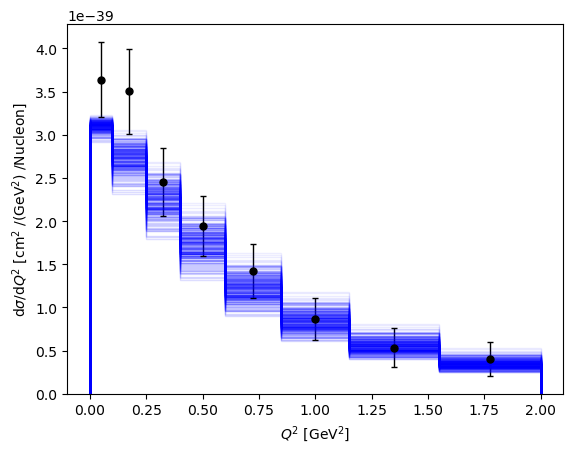

In [47]:
def add_pred(h, maresv):
    h.fill(ef, "Q2", [pn.HistFrame.fill_column(f"mares={maresv}"), pn.HistFrame.weight_by_array(mares_resp.eval(maresv))])

mc = data.make_HistFrame()

nthrows = 200

for v in np.random.normal(0,0.5,nthrows):
    add_pred(mc, v)

mcpred = mc.finalise(True).scale(gnorm.fatx_per_sumweights() * 1E-38)

icvmx = np.linalg.inv(cvmx)

for i in range(nthrows):
    datamc = np.squeeze(data.values[:,0] - mcpred.values[:,i+1]) * 1E38
    chi2 = np.squeeze(datamc.T @ icvmx @ datamc)
    mcpred.mpl().hist(histtype="step", color=(0,0,1,1.0/chi2), column=mcpred.column_info[i+1].name)

data.mpl().data_hist(label="MINERvA Data")

plt.ylabel(r"d$\sigma$/d$Q^{2}$ [cm$^{2}$ /(GeV$^{2}$) /Nucleon]")
plt.xlabel(r"$Q^{2}$ [GeV$^{2}$]")

plt.show()

## Implementing a new dataset

**This isn't quite finished**, but in its current state it highlights some of the *intrigue* of working with published data. There is probably something wrong with the signal definition, but improving the prediction is an exercise left to the reader. The data is correctly read in, and a model for how one might implement the prediction side of the analysis is given.

We're going to implement one distribution from this paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.131.011801

Data release here in csv format: https://arxiv.org/src/2209.07852v3/anc/Table_Var_Xsec.csv

We play some silly format games to turn the file we download into something that `numpy` can read in without too much massaging.

In [48]:
%%bash
if [ ! -e Table_Var_Xsec.csv ]; then
    wget https://arxiv.org/src/2209.07852v3/anc/Table_Var_Xsec.csv
fi
head -23 Table_Var_Xsec.csv
head -11 Table_Var_Xsec.csv | tail -8 | tr ";" "," | tr "-" "," > data.csv
head -23 Table_Var_Xsec.csv | tail -8 | tr ";" "," | tr "-" "," > covmx.csv

Measured cross section as function of $p_{\mu}$ on scintillator, in units of $10^{-42}$ $\text{cm}^2$/GeV/c/nucleon, and the absolute and fractional cross section uncertainties
---------------------------------------------------------------------------------------------------
Bin edges (GeV/c);  $\sigma$ ;  Abs. Unc. ;  Frac. Stat. Unc. ;  Frac. Sys. Unc. ;  Frac. Flux Unc.
1.5-3.0; 132.41; 9.94; 0.031; 0.068; 0.037
3.0-4.0; 339.29; 25.45; 0.022; 0.072; 0.037
4.0-5.0; 492.23; 37.09; 0.019; 0.073; 0.037
5.0-6.0; 521.41; 39.22; 0.017; 0.073; 0.037
6.0-7.0; 393.48; 30.19; 0.018; 0.074; 0.036
7.0-8.5; 177.43; 14.31; 0.022; 0.078; 0.035
8.5-10.0; 53.66; 4.89; 0.039; 0.082; 0.033
10.0-20.0; 9.51; 0.90; 0.046; 0.083; 0.035

Statistical covariance matrix of measured cross section as function of $p_{\mu}$ on scintillator, in units of $10^{-84}$ $(\text{cm}^2$/GeV/c/nucleon$)^2$
--------------------------------------------------------------------------------------------
Bin edges (GeV/c); 1.5-3.

In [49]:
data_np = np.genfromtxt("data.csv", delimiter=",")
cvmx_np = np.genfromtxt("covmx.csv", delimiter=",")[:,2:]

Now we have to play some silly type conversion games to get the NUISANCE binning functions to take the bin definitions

In [50]:
bin_edges = list(np.unique(data_np[:,0:2].reshape(1,data_np.shape[0]*2)))
print(bin_edges)
bins = pn.Binning.contiguous(bin_edges, r"$p_{\mu}$ [GeV/$c$]")
print(bins)

[1.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.5, 10.0, 20.0]
Axis lables: ["$p_{\\mu}$ [GeV/$c$]"]
Bins: [
  0: [(1.50 - 3.00)]
  1: [(3.00 - 4.00)]
  2: [(4.00 - 5.00)]
  3: [(5.00 - 6.00)]
  4: [(6.00 - 7.00)]
  5: [(7.00 - 8.50)]
  6: [(8.50 - 10.00)]
  7: [(10.00 - 20.00)]
]



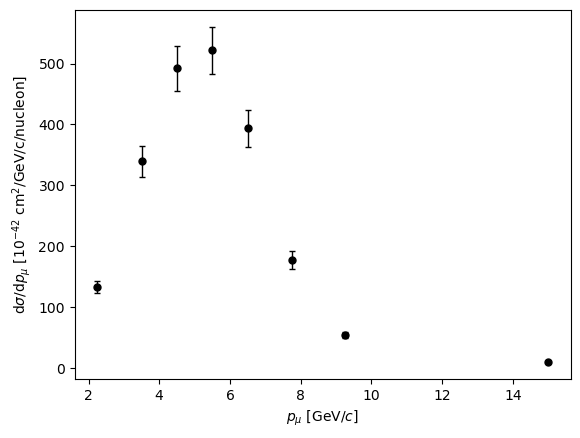

In [51]:
data = pn.BinnedValues(bins, "MINERvA arxiv:2209.07852", r"d$\sigma$/d$p_{\mu}$ [$10^{-42}$ $\mathrm{cm}^2$/GeV/c/nucleon]")
data.values = data_np[:,2]
data.errors = data_np[:,3]
data.mpl().data_hist()
plt.show()

### Running some new sim

This analysis is on MINERvA Medium Energy data, so we need some new events

In [52]:
%%bash
# uncomment to force regeneration
#rm genie_CH.MINERvA_ME.ghep.root
if [ ! -e genie_CH.MINERvA_ME.ghep.root ]; then
    gevgen -e 0.1,40 \
           -f $($NUISANCE/bin/nuis-flux MINERvA_ME -P numu -M nu) \
           -p 14 -t 1000060120[12],1000010010[1.00784] \
           -n 100000 \
           --tune $GENIE_XSEC_TUNE --cross-sections $GENIE_XSEC_FILE \
           --event-generator-list Default \
           -o genie_CH.MINERvA_ME.ghep.root &> genie.run.log
  if [ "$?" != 0 ]; then
    head -200 genie.run.log
  fi
fi

In [53]:
gevs = pn.EventSource({"event-generator-list":"Default",
                       "tune":"AR23_20i_00_000",
                       "spline_file":"/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz",
                       "filepath": "genie_CH.MINERvA_ME.ghep.root"})
if not gevs:
    print("Failed to read event file")

1734717921 NOTICE RunOpt : [n] <RunOpt.cxx::SetTuneName (85)> : RunOpt::SetTune() already had AR23_20i_00_000, now being re-set to AR23_20i_00_000
1734717921 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734717921 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734717921 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 


### Implementing the signal definition

The signal definition from the paper is copied below:

```
Signal reactions for this measurement are νµ charged-current interactions which produce
a single negatively charged muon and a single positively charged pion. Any number of
baryons may be in the final state; however, no other mesons may be produced. To match
MINERvA’s acceptance, the muon is restricted in momentum (pµ) and angle with respect
to the neutrino beam (θµ), such that 1.5 < pµ < 20 GeV/c and θµ < 13◦. Pion kinetic
energy (Tπ) is restricted to 35 <Tπ <350 MeV.

To enhance reactions involving a ∆ baryon resonance, a selection is made on the invariant
hadronic mass of the final state. We define W_exp = M^2 + 2 M E_had − Q^2, where Ehad = Eν−Eµ,
M is the average of the proton and neutron masses. Wexp is the invariant mass of the hadronic
final state under the assumption that the target nucleon is at rest. Wexp is required to be
less than 1.4 GeV/c2.
```

There is a confusing detail in the above text. Wexp has units of mass squared. I suspect it should be $W^2_\mathrm{exp}$

we need to write a selection function matching this definition, our attempt is below.

In [54]:
from pyProSelecta import costheta, kinetic_energy
from math import sqrt

def W2exp_GeV2_c4(ev):

    if event.num_out_part(ev, pdg.kMuon) != 1:
        return pn.pps.kMissingDatum
    
    M = 938.27 * unit.MeV_c2
    nu = event.beam_part(ev)
    mu = event.hm_out_part(ev, pdg.kMuon)

    d4mom = (nu.momentum() - mu.momentum())
    Q2 = -d4mom.interval() / unit.MeV2
    EHad = d4mom.e() / unit.MeV

    return (pow(M,2) + 2*M*EHad - Q2) / unit.GeV2

def mnv1pip_sel(ev):
    # check that we have the right in/out particles
    if not (event.has_beam_part(ev, pdg.kNuMu) \
            and (event.num_out_part(ev, pdg.kMuon) == 1) \
            and (event.num_out_part(ev, pdg.kPiPlus) == 1) ):
        return False

    # check that we don't have any unexpected out particles
    if event.num_out_part_except(ev, [pdg.kMuon, pdg.kPiPlus, \
                                      pdg.kProton, pdg.kNeutron, \
                                      pdg.kGamma]) > 0:
        return False

    # get the relevant particles for phase space cuts
    nu = event.beam_part(ev)
    mu, pip = event.hm_out_part(ev, [pdg.kMuon, pdg.kPiPlus])

    mucut = (costheta(nu.momentum()) < (13 * unit.deg)) \
            and (p3mod > 1.5 * unit.GeV) \
            and (p3mod < 20 * unit.GeV)
    
    picut = (kinetic_energy > 35 * unit.MeV) \
            and (kinetic_energy < 350 * unit.MeV)
    
    if not (mucut(mu) and picut(pip)):
        return False

    return True
    

In [58]:
efg = pn.EventFrameGen(gevs) \
        .filter(mnv1pip_sel) \
        .add_column("wexpcut", lambda ev: sqrt(W2exp_GeV2_c4(ev)) < 1.4) \
        .add_column("plep", ext.plep_GeV)
print(efg.first(20))

 -----------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id | wexpcut |  plep |
 -----------------------------------------------------------------------------------------
 |           54 |         1 |     0.005741 |     0.001166 |        400 |       0 | 4.399 |
 |           64 |         1 |     0.004826 |     0.000985 |        500 |       0 | 6.692 |
 |           99 |         1 |     0.003693 |    0.0006379 |        400 |       1 | 7.226 |
 |          105 |         1 |     0.003216 |    0.0005981 |        400 |       1 | 4.406 |
 |          123 |         1 |     0.002698 |    0.0005165 |        700 |       1 | 5.293 |
 |          141 |         1 |     0.002566 |    0.0004626 |        400 |       1 | 5.539 |
 |          151 |         1 |       0.0022 |    0.0004277 |        400 |       1 | 2.945 |
 |          154 |         1 |      0.00208 |     0.000416 |        600 |       0 | 4.462 |

In [59]:
ef = efg.all()
gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)

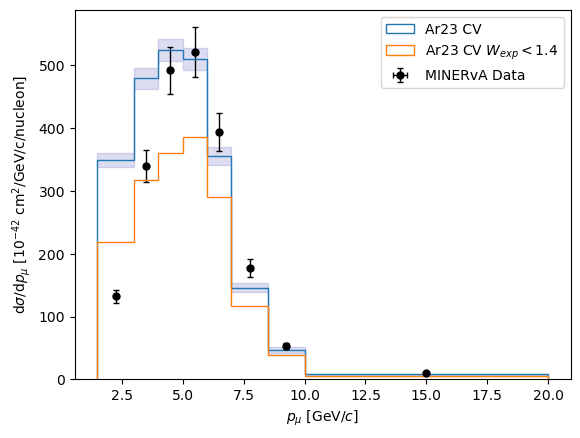

In [60]:
mc = data.make_HistFrame()

mc.fill(ef, "plep")
mc.fill(ef, "plep", [pn.HistFrame.fill_column("wexpcut"), pn.HistFrame.fill_if("wexpcut")])

# required because this analysis is in 1E-42 cm^2 /N not the nuisance2 default of 1E-38 cm2/N
ana_scale = 1E4

# The True passed to finalise tells it to divide by the bin width, so that the returned 
# prediction can be treated as an estimate of the differential cross section
mcpred = mc.finalise(True).scale(ana_scale * gnorm.fatx_per_sumweights())

mcpred.mpl().hist(histtype="step", errorband_color="#0092", label="Ar23 CV")
mcpred.mpl().hist(histtype="step", column="wexpcut", label=r"Ar23 CV $W_{exp} < 1.4$")

data.mpl().data_hist(label="MINERvA Data")

plt.legend()

plt.show()